# Generation of model behind PROCEED (PROjeCt ExomE Depth)
**Access the streamlit hosted [PROCEED application](http://share.streamlit.io/danielanach/proceed/main/PROCEED.py)**

The overall goal of this model is to predict exome depth (or coverage), from limited parameters obtained during the DNA library preparation of samples for suboptimal FFPE DNA samples in order to help guide the decisions whether a sample should be sequenced or not.  

# Table of contents
1. [Processing input data](#process-data)
2. [Train multiple linear regression model](#model-data)
3. [Evaluate model](#evaluate-model)

In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
sns.set_context("paper")
    
# Set the font to be serif, rather than sans
sns.set(font='arial',font_scale=1.5)

# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "arial",'axes.grid': False,"font.size":14,"axes.labelsize":14})

# 1. Processing input data <a class="anchor" id="process-data"></a>
This data is a compilation of both published and un-published FFPE DNA samples which have already been exome sequenced and includes bulk FFPE samples and laser-capture micro-dissected samples from oral premalignant lesions [1] and breast pre-cancer [2-3]. 


**References:**

> 1. Gutkind,J.S. et al. (2021) Inhibition of mTOR signaling and clinical activity of metformin in oral premalignant lesions. *JCI Insight*, 6.
> 2. Nachmanson,D. et al. The breast pre-cancer atlas illustrates the molecular and micro-environmental diversity of ductal carcinoma in situ. npj Breast Cancer, *In Press*.
> 3. Nachmanson,D. et al. (2020) Mutational profiling of micro-dissected pre-malignant lesions from archived specimens. *BMC Med. Genomics*, 13, 173.

In [3]:
data = pd.read_csv('ffpe_DNA_seq_training_data_clean.csv')
data['total_reads_M'] = data['total_reads']/1000000

## Choosing representative sample from DNA replicates
In the case that multiple libraries were prepared from the same FFPE DNA extraction, we are only keeping data from one of these libraries. Since decisions about which samples to continue on through exome sequencing typically tend to be those that have little input DNA, we chose to keep the lowest DNA input amount.

In [4]:
data = data.sort_values(by='input_DNA_ng').drop_duplicates(subset='dna',keep='first')

## Statistics of select data features

In [5]:
median_input = np.median(data['input_DNA_ng'])
print('Median DNA input = {} ng'.format(median_input))
print('Range DNA input = ({}, {})'.format(min(data['input_DNA_ng']),max(data['input_DNA_ng'])))

Median DNA input = 17.15 ng
Range DNA input = (2.0, 309.0)


In [6]:
data.groupby(by='kit').size()

kit
Swift 2S           90
Ultra_II_NEB_FS    54
XTHS               22
dtype: int64

In [7]:
num_samples = len(data['case'].unique())
print('Number of unique samples: {}'.format(num_samples))

Number of unique samples: 124


## Plotting raw data

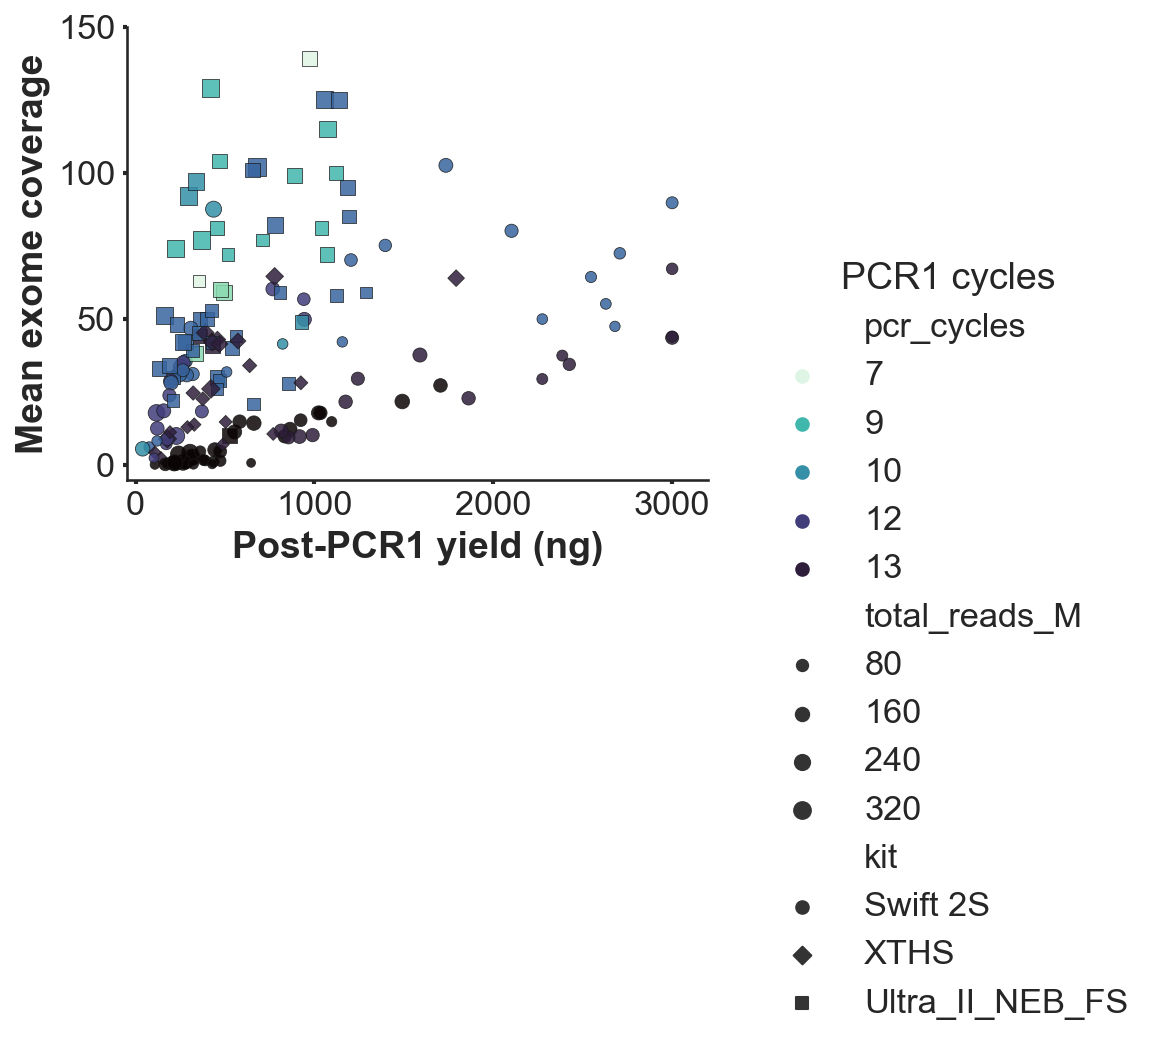

In [8]:
plt.figure(figsize=(5,4),dpi=150)

data['post_pcr1_dna_clip'] = np.clip(data['post_pcr1_dna'],a_min=0,a_max=3000)
sns.scatterplot(data=data,
               x='post_pcr1_dna_clip',
               y='average_coverage',
               palette='mako_r',
               edgecolor='k',
               alpha=0.85,
               size='total_reads_M',
               hue='pcr_cycles',
               style='kit',
               style_order=['Swift 2S','XTHS','Ultra_II_NEB_FS'],
               markers=['o','D','s'],
               s=200)
plt.xlim(-50,3200)
plt.ylim(-5,150)
sns.despine(right = True)
plt.legend(bbox_to_anchor=(1.05,0.55),title='PCR1 cycles',frameon=False)
plt.xlabel('Post-PCR1 yield (ng)',fontweight='bold')
plt.ylabel('Mean exome coverage',fontweight='bold')
plt.tick_params(axis = 'x', which = 'major',size=2,width=2,direction='out', bottom='on')
plt.tick_params(axis = 'y', which = 'major',size=2,width=2,direction='out', left='on')
plt.savefig('PCR1_yield_and_exome_coverage.pdf',dpi=150,bbox_inches='tight')

## Plotting distribution of all numerical variables included in model
Looking at different ways of normalizing the features and which reduces skew the most:
1. Log transformation
2. Square root transformation
3. Box-cox transformation

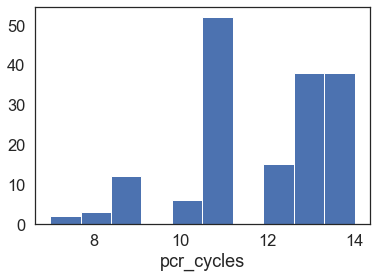

Skew = -0.578624


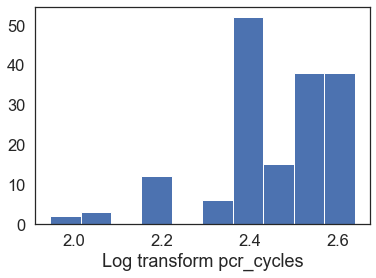

Skew = nan


/Users/d/work/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


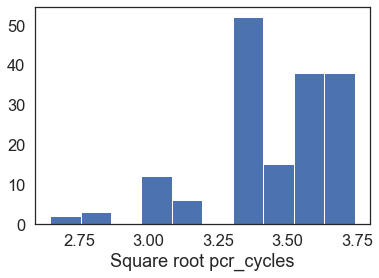

Skew = -0.758247


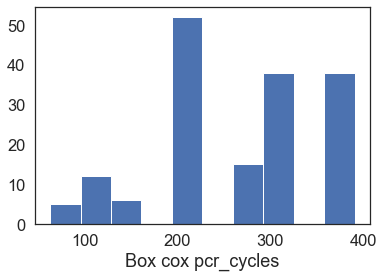

Skew = -0.133520


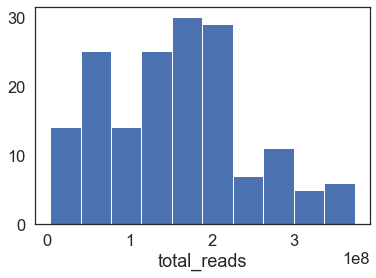

Skew = 0.342939


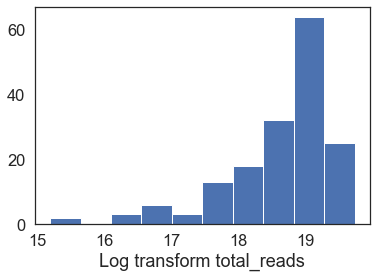

Skew = -1.070203


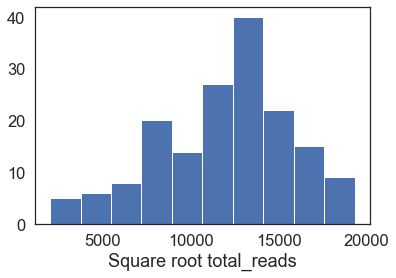

Skew = -0.440869


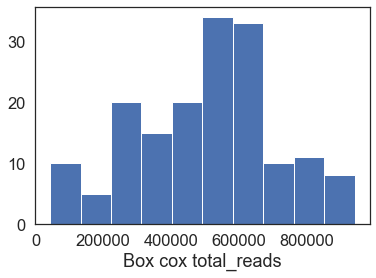

Skew = -0.135402


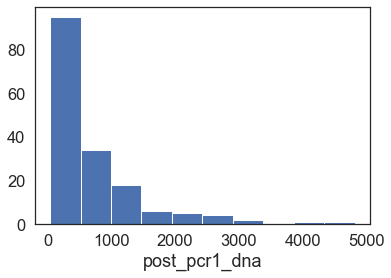

Skew = 2.496782


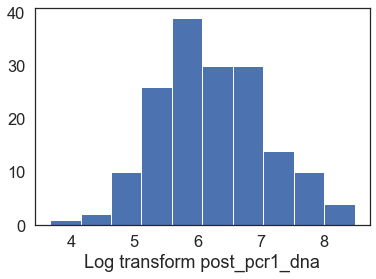

Skew = 0.915003


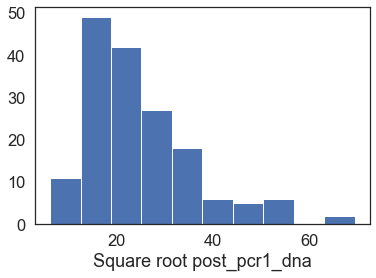

Skew = 1.323825


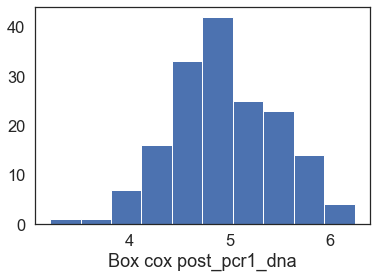

Skew = 0.001491


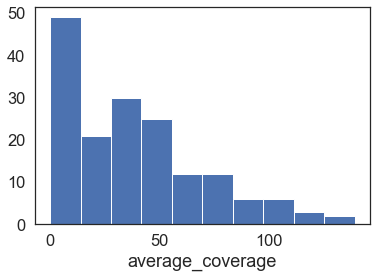

Skew = 0.941352


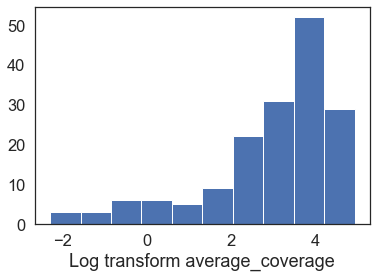

Skew = -0.060438


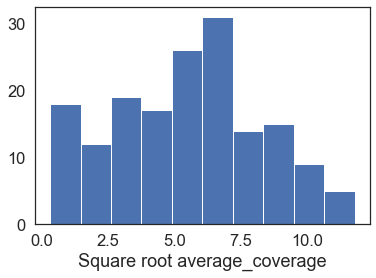

Skew = -0.008768


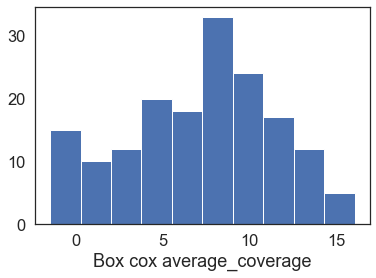

Skew = -0.217635


In [9]:
for i in ['pcr_cycles','total_reads','post_pcr1_dna','average_coverage']:
    
    # Raw data
    plt.hist(data[i],bins=10)
    plt.xlabel(i)
    plt.show()
    print('Skew = {:2f}'.format(data[i].skew()))
    
    # Log transform
    plt.hist(np.log(data[i]),bins=10)
    plt.xlabel('Log transform {}'.format(i))
    plt.show()
    print('Skew = {:2f}'.format(np.log(data[i].skew())))
    
    # Square root transform
    plt.hist(np.sqrt(data[i]),bins=10)
    plt.xlabel('Square root {}'.format(i))
    plt.show()
    print('Skew = {:2f}'.format(np.sqrt(data[i]).skew()))
    
    # Box-cox
    plt.hist(scipy.stats.boxcox(data[i])[0],bins=10)
    plt.xlabel('Box cox {}'.format(i))
    plt.show()
    print('Skew = {:2f}'.format(pd.Series(scipy.stats.boxcox(data[i])[0]).skew()))

## Normalizing the data:

In [10]:
# For box-cox normalization saving the lambda so that can apply to new input data
lambda_dct = {}
data['pcr_cycles_norm'], lambda_dct['pcr_cycles'] = scipy.stats.boxcox(data['pcr_cycles'])
data['total_reads_norm'], lambda_dct['total_reads'] = scipy.stats.boxcox(data['total_reads'])
data['post_pcr1_dna_norm'], lambda_dct['post_pcr1_dna'] = scipy.stats.boxcox(data['post_pcr1_dna'])

data['average_coverage_norm'] = np.sqrt(data['average_coverage'])

## Writing box-cox lambda exponents to dictionary

In [11]:
with open('../boxcox_lambda_exponents.json', 'w') as convert_file:
     convert_file.write(json.dumps(lambda_dct))

# 2. Modeling the average exome coverage based on: <a class="anchor" id="model-data"></a>
* Total reads
* PCR 1 cycles
* PCR 1 DNA yield
* Kit type used

In [12]:
print('Overall performance\n')
formula = 'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm + C(kit)'

model = smf.ols(formula=formula, data=data,).fit()
print(model.summary())

Overall performance

                              OLS Regression Results                             
Dep. Variable:     average_coverage_norm   R-squared:                       0.853
Model:                               OLS   Adj. R-squared:                  0.848
Method:                    Least Squares   F-statistic:                     185.7
Date:                   Wed, 03 Nov 2021   Prob (F-statistic):           1.05e-64
Time:                           15:05:05   Log-Likelihood:                -247.74
No. Observations:                    166   AIC:                             507.5
Df Residuals:                        160   BIC:                             526.2
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## Writing parameters of model to dictionary

In [13]:
model_params = dict(model.params)
with open('../model_params.json', 'w') as convert_file:
     convert_file.write(json.dumps(model_params))

# 3. Evaluate model <a class="anchor" id="evaluate-model"></a>

## Evaluating R^2 values removing each feature

In [14]:
formula = 'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm + C(kit)'
model = smf.ols(formula=formula, data=data,).fit()
total_rsquared_adj = model.rsquared_adj

rsquared_adj_lst = []
rsquared_adj_params = ['Reads','PCR cycles','PCR yield','Kit' , 'PCR cycles and yield']

for f in ['average_coverage_norm ~ pcr_cycles_norm + post_pcr1_dna_norm + C(kit)',
         'average_coverage_norm ~ total_reads_norm + post_pcr1_dna_norm + C(kit)',
         'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + C(kit)',
         'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm',
         'average_coverage_norm ~ total_reads_norm + C(kit)']:
    
    model = smf.ols(formula=f, data=data,).fit()
    rsquared_adj = model.rsquared_adj
    rsquared_adj_lst.append(rsquared_adj)

model_eval_df = pd.DataFrame(zip(rsquared_adj_params,rsquared_adj_lst),columns=['variable','rsquared_adj'])
model_eval_df['delta_rsquared_adj'] = total_rsquared_adj - model_eval_df['rsquared_adj']
model_eval_df['total_rsquared_adj'] = total_rsquared_adj
model_eval_df = model_eval_df.sort_values(by='rsquared_adj',ascending=False)

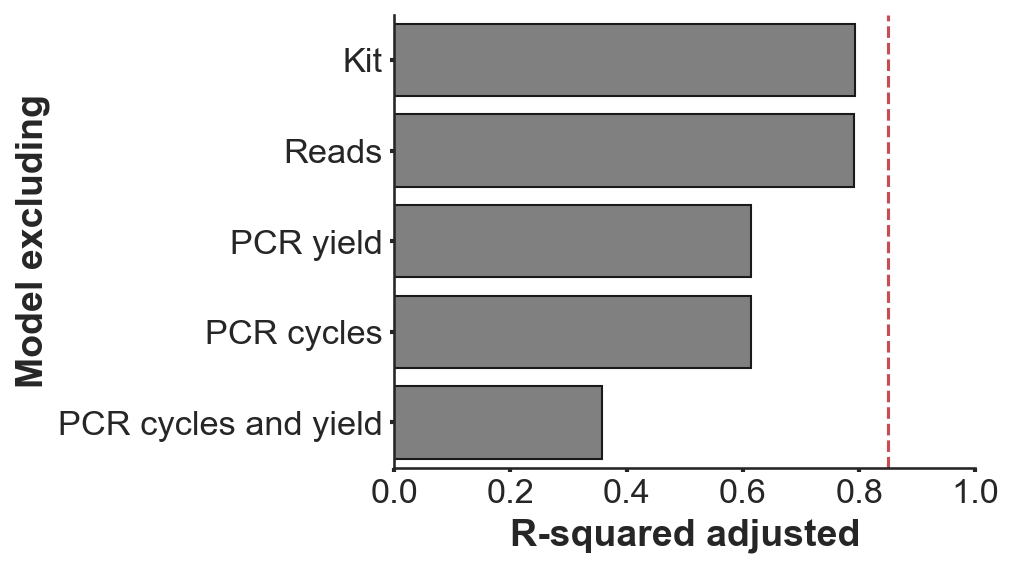

In [15]:
plt.figure(figsize=(5,4),dpi=150)

sns.barplot(data=model_eval_df,
            y='variable',
            x='rsquared_adj',
            color='grey',
            edgecolor='k')

plt.xlabel('R-squared adjusted',fontweight='bold')
plt.ylabel('Model excluding',fontweight='bold')

sns.despine(right = True)
plt.tick_params(axis = 'x', which = 'major',size=2,width=2,direction='out', bottom='on')
plt.tick_params(axis = 'y', which = 'major',size=2,width=2,direction='out', left='on')

plt.xlim(0,1)
plt.axvline(x=0.85,color='r',linestyle='--')

plt.savefig('Rsquared_adj_variable_Eval.pdf',dpi=150,bbox_inches='tight')

## Estimating overall goodness of fit
Using root mean squared error

In [20]:
formula = 'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm + C(kit)'

rmse_lst = []
predicted_all = []
observed_all = []
for i in range(0,1000):
    
    train, test = train_test_split(data,test_size=0.1)

    # Fit model to training data
    test_model = smf.ols(formula=formula, data=train).fit()

    # Predict average coverage
    prediction = test_model.predict(test)

    predicted_values = np.square(prediction)
    observed_values = np.square(test['average_coverage_norm'])
    # RMSE
    # Both the prediction and the actual values of coverage will be squared 
    # since in the normalization the square root was taken 
    rmse = np.sqrt(metrics.mean_squared_error(observed_values, 
                                              predicted_values))
    rmse_lst.append(rmse)
                   
    predicted_all.extend(predicted_values)
    observed_all.extend(observed_values)

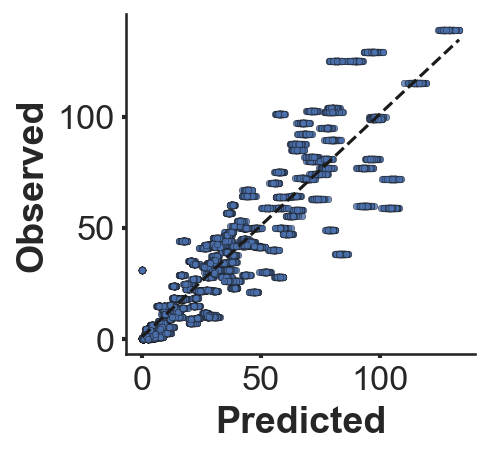

In [21]:
plt.figure(figsize=(3,3),dpi=150)
sns.scatterplot(y=observed_all,
                x=predicted_all,
                s=10,
                alpha=0.8,
                edgecolor='k')
plt.ylabel('Observed',fontweight='bold')
plt.xlabel('Predicted',fontweight='bold')

x=predicted_all
y=observed_all

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='k',linestyle='--')

sns.despine(right = True)
plt.tick_params(axis = 'x', which = 'major',size=2,width=2,direction='out', bottom='on')
plt.tick_params(axis = 'y', which = 'major',size=2,width=2,direction='out', left='on')
plt.savefig('Cross_validation_scatter.pdf',dpi=150,bbox_inches='tight')

plt.show()

/Users/d/work/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


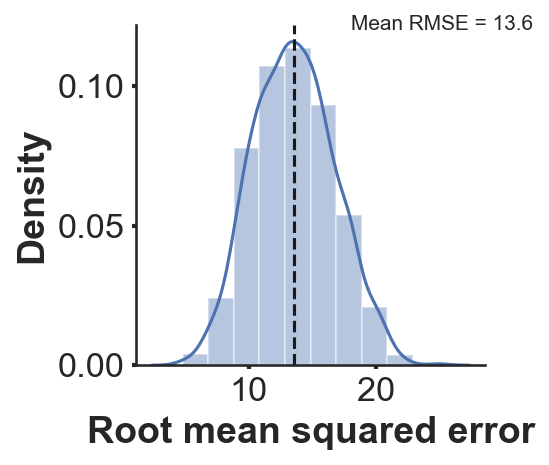

In [22]:
plt.figure(figsize=(3,3),dpi=150)
sns.distplot(rmse_lst,bins=10)
plt.xlabel('Root mean squared error',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
sns.despine(right = True)
plt.tick_params(axis = 'x', which = 'major',size=2,width=2,direction='out', bottom='on')
plt.tick_params(axis = 'y', which = 'major',size=2,width=2,direction='out', left='on')
plt.axvline(x=np.average(rmse_lst),linestyle='--',color='k')
plt.text(18,0.12,'Mean RMSE = {:.3}'.format(np.average(rmse_lst)),
         fontsize=10)
plt.savefig('RMSE_average_coverage.pdf',dpi=150,bbox_inches='tight')

##  Miscellaneous useful plots

Text(0, 0.5, 'Percent bases >= 20x')

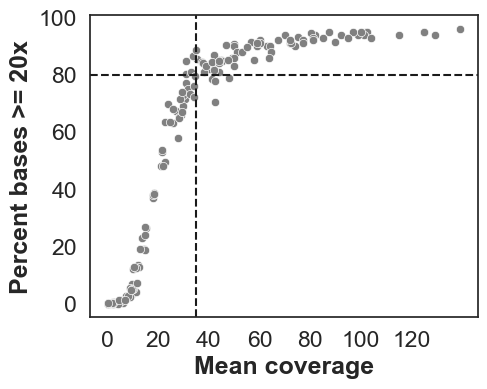

In [19]:
plt.figure(figsize=(5,4),dpi=100)
sns.scatterplot(data=data,
                x='average_coverage',
                y='cov20',
                color='grey')
plt.axvline(x=35,linestyle='--',color='k')
plt.axhline(y=80,linestyle='--',color='k')
plt.xticks(np.arange(0, max(data['average_coverage'])+1, 20))
plt.xlabel('Mean coverage',fontweight='bold')
plt.ylabel('Percent bases >= 20x',fontweight='bold')